# Notebook to read in brownian simulation output and animate the data


## Create Animation by calling c++ code from bash.
- Modifications to physical parameters are handled in main.cpp

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Get Geometric Info
print 'GEOMETRY PARAMS--------------------------------------------------'
params = pd.read_csv('params.txt',sep='\t')
R = params.R[0]
a = params.a[0]
T = params.temp[0]
r_enc = params.r_enc[0]
N_ants = params.num_ants[0]
coll_flag = params.collision_flag[0]
print '\tBox Radius: ',R
print '\tAperture Size: ',a
print '\tNumber of Ants: ',N_ants
print '\tEncounter Radius: ',r_enc
print '\tTemperature: ',T
if coll_flag == 1:
    print '\tCollisions On.'
else:
    print '\tCollisions Off.'

## Get Simulation Info
print 'SIMULATION PARAMS------------------------------------------------'
data = pd.read_csv('output.txt',sep='\t')
uniq_time = np.unique(data.event_time)
t_max = uniq_time[-1]
t_min = uniq_time[1]-uniq_time[0]
for i in range(np.size(uniq_time)-1):
    delta_t = uniq_time[i+1] - uniq_time[i]
    if delta_t < t_min:
        t_min = delta_t
N_events = data.shape[0]/N_ants
print '\tNumber of Events: ',N_events
print '\tTotal Time: ',t_max
print '\tMinimum Time Between Events: ',t_min

## Animation Parameters
print 'ANIMATION PARAMS-------------------------------------------------'
N_frames = 400
output_every = 1
plot_dir = '/Users/jakehanson/Documents/Ants/plots/'
output_path = '/Users/jakehanson/Desktop/sim.gif'
dt = t_max/N_frames
print '\tNumber of Frames: ',N_frames
print '\tOutput Every: ',output_every
print '\tOutput Resolution: ',dt*output_every
print '\tPlot Directory: ',plot_dir
print '\tAnimation Output: ',output_path


## Generate Disk for Animation
N_points = 100
x_disk = []
y_disk = []
theta_crit = a/R
for i in range(N_points+1):
    x = R*np.cos((np.pi+theta_crit)/2+(2*np.pi-theta_crit)*i/N_points)
    y = R*np.sin((np.pi+theta_crit)/2+(2*np.pi-theta_crit)*i/N_points)
    x_disk.append(x)
    y_disk.append(y)

    
## GENERATE ANIMATION
print 'RUNNING ANIMATION------------------------------------------------'
!rm $plot_dir/*
time_array = np.linspace(0,t_max,N_frames)  #generate evenly spaced time series
counter = -1


#Since the simulation is event based, we need to smoothly interpolate data through time
for t in time_array:
    counter = counter+1
    
    # get index of data array at the most recent time possible
    for j in range(np.size(uniq_time)):
        if uniq_time[j]-t <= 0.:
            index = j*N_ants
            
    # Initialize arrays to hold data for this frame
    x_positions, y_positions = [], []
    
    # Get x,y positions of ants at this time step
    for ant in range(N_ants):
        current_time = data.event_time[index]
        next_time=data.event_time[index+ant]
        if current_time != next_time:
            print "\tERROR: Not in same timestep!!\n"
            
        if data.in_nest[index+ant] == 1:
            interpolate_x = data.x[index+ant]+data.v_x[index+ant]*(t-data.event_time[index+ant])
            interpolate_y = data.y[index+ant]+data.v_y[index+ant]*(t-data.event_time[index+ant])
            x_positions.append(interpolate_x)
            y_positions.append(interpolate_y)
            
    ## Plot
    if counter%output_every == 0:
        print '\tCounter {:d}/{:d}'.format(counter,N_frames)
        print '\t\tN =',np.size(x_positions)
        plt.plot(x_disk,y_disk,color='k',linestyle='-',linewidth=2)
        #plt.axis('off')
        #plt.title('Time: {:5.4f}'.format(t))
        plt.title('R={:2.1f}, a={:2.1f}, r_encounter={:2.1f}'.format(R,a,r_enc))
        plt.scatter(x_positions,y_positions,s=100,color='k',alpha=0.7)
        plt.xlim((-R,R))
        plt.ylim((-R,R))
        plt.axes().set_aspect('equal', 'datalim')
        fname = ('plot' + '_%06d.png' % (counter))  # assign filename
        plt.savefig(plot_dir+fname)
        plt.clf()

plt.close()
print 'RUNNING CONVERSION-----------------------------------------------'
!convert $plot_dir/* $output_path
print 'DONE!'

GEOMETRY PARAMS--------------------------------------------------
	Box Radius:  0.95
	Aperture Size:  0.1
	Number of Ants:  1
	Encounter Radius:  0.1
	Temperature:  5
	Collisions On.
SIMULATION PARAMS------------------------------------------------
	Number of Events:  60
	Total Time:  22.4679
	Minimum Time Between Events:  0.3808
ANIMATION PARAMS-------------------------------------------------
	Number of Frames:  400
	Output Every:  1
	Output Resolution:  0.05616975
	Plot Directory:  /Users/jakehanson/Documents/Ants/plots/
	Animation Output:  /Users/jakehanson/Desktop/sim.gif
RUNNING ANIMATION------------------------------------------------
	Counter 0/400
		N = 1
	Counter 1/400
		N = 1
	Counter 2/400
		N = 1
	Counter 3/400
		N = 1
	Counter 4/400
		N = 1
	Counter 5/400
		N = 1
	Counter 6/400
		N = 1
	Counter 7/400
		N = 1
	Counter 8/400
		N = 1
	Counter 9/400
		N = 1
	Counter 10/400
		N = 1
	Counter 11/400
		N = 1
	Counter 12/400
		N = 1
	Counter 13/400
		N = 1
	Counter 14/400
		N = 1


## Run the above code 4 times for 4 different nest geometries!
- Cavity Diameter / Entrance Width
- 19 mm / 1 mm
- 19 mm / 5 mm
- 38 mm / 2 mm
- 38 mm / 10 mm
- Assume encounter radius is 0.1 and temperature of 5

In [4]:
## Use this code to store data as an array
## This specific version is for 38mm diameter 10 mm aperture

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

N_sims = 300  # number of times to run simulation
n_steps = 10000  # number of steps in a given trial (this is hardcoded in sim)
n_ants = 1  # ants per sim (also hardcoded)
Temp = 5  # Temperature (also hardcoded)
time_spent_19mm_5mm = []  # array to hold time spent

for i in range(N_sims):
    !./run_sim.exe
    data = pd.read_csv('output.txt',sep='\t')
    n_rows = data.shape[0]
    time_spent = data[n_rows-n_ants:n_rows]['exit_time']
    time_spent_19mm_5mm.extend(time_spent)
    if i % 100 == 0:
        print '{:d}/{:d}'.format(i,N_sims)

print 'Done'

0/300
100/300
200/300
Done


## Generate Histogram for Data

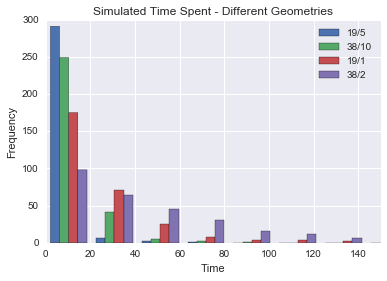

In [5]:
plt.hist([time_spent_19mm_5mm,time_spent_38mm_10mm,time_spent_19mm_1mm,time_spent_38mm_2mm],label=\
         ['19/5','38/10','19/1','38/2'],bins=120,stacked=False)
plt.xlim(0,150)
plt.title('Simulated Time Spent - Different Geometries')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig('/Users/jakehanson/Desktop/time_spent_hist.pdf')
plt.show()

## Theoretically, the average time spent inside is given by:

<h3><center>
$ \langle t_{inside} \rangle = \frac{8 r^2}{av_{rms} } $
</center></h3>

#### We can compare how well the simulation and the experiment match up to this fit

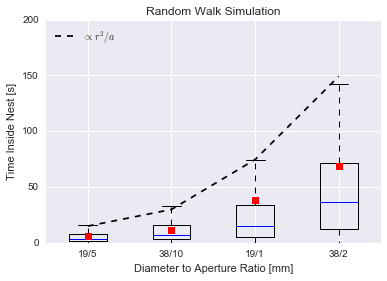

In [9]:
## FIT THE SIMULATION

# hardcode initial values for theoretical fit
#r_0 = 1.9
#a_0 = 0.5

v_rms = np.sqrt(3.*5)

## add theoretical fit centered on first data point
def get_time_inside(r,a):
    return 8*r**2/(a*v_rms)
    #return (r/r_0)**2/(a/a_0)*6.05

plt.boxplot([time_spent_19mm_5mm,time_spent_38mm_10mm,time_spent_19mm_1mm,time_spent_38mm_2mm],labels=\
         ['19/5','38/10','19/1','38/2'],showmeans=True,medianprops=dict(color='blue'),boxprops=dict(color='black'),\
           whiskerprops=dict(color='black'))
plt.plot([1,2,3,4],[get_time_inside(1.9,0.5),get_time_inside(3.8,1.0),\
                    get_time_inside(1.9,0.1),get_time_inside(3.8,0.2)],linestyle='--',\
                     color = 'black',label=r'$ \propto r^2/a$')
plt.ylabel('Time Inside Nest [s]')
plt.xlabel('Diameter to Aperture Ratio [mm]')
plt.ylim((0,200))
plt.title('Random Walk Simulation')
plt.legend(loc='upper left')
#plt.savefig('/Users/jakehanson/Desktop/temp.pdf')
plt.show()

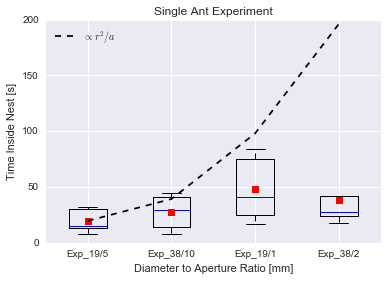

In [183]:
## FIT THE REAL EXPERIMENTAL DATA

## add theoretical fit centered on first data point
def get_time_inside(r,a):
    #return 2*np.pi*r**2/(a*v_rms)
    return (r/r_0)**2/(a/a_0)*19.6

plt.boxplot([exp_19_5,exp_38_10,exp_19_1,exp_38_2],labels=['Exp_19/5','Exp_38/10','Exp_19/1','Exp_38/2'],\
            showmeans=True,medianprops=dict(color='blue'),boxprops=dict(color='black'),whiskerprops=dict(color='black'))
plt.plot([1,2,3,4],[get_time_inside(1.9,0.5),get_time_inside(3.8,1.0),\
                    get_time_inside(1.9,0.1),get_time_inside(3.8,0.2)],linestyle='--',\
                     color = 'black',label=r'$ \propto r^2/a$')
plt.ylabel('Time Inside Nest [s]')
plt.xlabel('Diameter to Aperture Ratio [mm]')
plt.ylim((0,200))
plt.title('Single Ant Experiment')
plt.legend(loc='best')
#plt.savefig('/Users/jakehanson/Desktop/temp2.pdf')
plt.show()

## The experiment doesn't show the correct trend, nor is the trend strong enough where it does match.
The ants are clearly doing something different. Next, we will add in interaction time. This means that every time an ant has a collision there is a delay. This delay corresponds to the time the ant takes to antennate whatever it runs into. In regards to the simulation, this means that more collisions yields a slower average velocity. Thus, the velocity will no longer be constant across all nests and apertures, nor will it be independent of density. This will change the simulation results and possibly provide insight into the time spent inside as a function of nest density as well.